# איסוף נתונים כלכליים - שווי סגלים

המטרה: לאסוף נתוני שווי סגלים מטרנספרמרקט לכל הקבוצות בליגת העל, בכל עונה.

## מה נאסוף:
- **שווי סגל כולל** - הערך הכולל של כל הסגל (€m)
- **מספר שחקנים** - כמה שחקנים בסגל
- **גיל ממוצע** - הגיל הממוצע של הסגל
- **השחקן היקר ביותר** - שם ושווי השחקן הכי יקר בקבוצה
- **שווי שוק ממוצע** - שווי ממוצע לשחקן

## טווח עונות:
2006/07 - 2025/26

## 1. Environment Setup

In [13]:
# Environment setup
from pathlib import Path
from typing import Optional
import sys

try:
    from dotenv import load_dotenv
    DOTENV_AVAILABLE = True
except Exception:
    DOTENV_AVAILABLE = False

# Helper to find project root
def _find_root(start: Optional[Path] = None) -> Path:
    p = start or Path.cwd()
    for _ in range(6):
        if (p / 'data').exists() or (p / '.git').exists() or (p / 'notebooks').exists():
            return p
        p = p.parent
    return Path.cwd()

# Resolve project directories consistently
ROOT = _find_root()
DATA_DIR = ROOT / 'data'
RAW_DIR = DATA_DIR / 'raw'
INTERIM_DIR = DATA_DIR / 'interim'
PROCESSED_DIR = DATA_DIR / 'processed'
ECONOMIC_DIR = DATA_DIR / 'economic_data'
FIG_DIR = ROOT / 'reports' / 'figures'

# Create directories
for d in [RAW_DIR, INTERIM_DIR, PROCESSED_DIR, ECONOMIC_DIR, FIG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print(f"🎯 Environment setup complete")
print(f"   ROOT: {ROOT}")
print(f"   DATA_DIR: {DATA_DIR}")
print(f"   ECONOMIC_DIR: {ECONOMIC_DIR}")

🎯 Environment setup complete
   ROOT: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks
   DATA_DIR: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\data
   ECONOMIC_DIR: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\data\economic_data


## 2. Import Libraries

In [14]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time
import random
from datetime import datetime
import re
from typing import Dict, List, Tuple, Optional
import warnings
from IPython.display import display
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully")

✅ All libraries imported successfully


## 3. Helper Functions

In [15]:
# User agents for scraping
_USER_AGENTS = [
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0 Safari/537.36",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/17.0 Safari/605.1.15",
    "Mozilla/5.0 (X11; Linux x86_64; rv:109.0) Gecko/20100101 Firefox/121.0",
]

def get_random_user_agent() -> str:
    """Return a random user agent string."""
    return random.choice(_USER_AGENTS)

def safe_sleep(min_sec: float = 1.0, max_sec: float = 3.0) -> None:
    """Sleep for a random duration to avoid rate limiting."""
    time.sleep(random.uniform(min_sec, max_sec))

def fetch_page(url: str, max_retries: int = 3) -> Optional[BeautifulSoup]:
    """
    Fetch a web page and return parsed HTML.
    
    Args:
        url: URL to fetch
        max_retries: Maximum number of retry attempts
        
    Returns:
        BeautifulSoup object or None if failed
    """
    headers = {
        'User-Agent': get_random_user_agent(),
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
        'Accept-Language': 'en-US,en;q=0.5',
        'Accept-Encoding': 'gzip, deflate',
        'Connection': 'keep-alive',
    }
    
    for attempt in range(max_retries):
        try:
            response = requests.get(url, headers=headers, timeout=15)
            response.raise_for_status()
            return BeautifulSoup(response.content, 'html.parser')
        except Exception as e:
            print(f"   ⚠️ Attempt {attempt + 1}/{max_retries} failed: {str(e)}")
            if attempt < max_retries - 1:
                safe_sleep(2, 5)
    
    return None

print("✅ Helper functions defined")

✅ Helper functions defined


## 4. Explore Transfermarkt Structure

בואו נבדוק את המבנה של דף הליגה בטרנספרמרקט ונבין איך לחלץ את הנתונים שאנחנו צריכים.

In [16]:
# URL לעונה הנוכחית של ליגת העל
test_url = "https://www.transfermarkt.com/ligat-haal/startseite/wettbewerb/ISR1/saison_id/2025"

print(f"📥 Fetching page: {test_url}")
soup = fetch_page(test_url)

if soup:
    print("✅ Page fetched successfully!")
    
    # בואו נחפש את הטבלה עם הקבוצות
    table = soup.find('table', {'class': 'items'})
    
    if table:
        print("\n✅ Found clubs table!")
        
        # נדפיס את מספר השורות בטבלה
        rows = table.find('tbody').find_all('tr')
        print(f"   Number of teams: {len(rows)}")
        
        # נבדוק את השורה הראשונה
        if rows:
            first_row = rows[0]
            print("\n🔍 First row structure:")
            print(first_row.prettify()[:1000])
    else:
        print("❌ Could not find clubs table")
else:
    print("❌ Failed to fetch page")

📥 Fetching page: https://www.transfermarkt.com/ligat-haal/startseite/wettbewerb/ISR1/saison_id/2025
✅ Page fetched successfully!

✅ Found clubs table!
   Number of teams: 14

🔍 First row structure:
<tr class="odd">
 <td class="zentriert no-border-rechts">
  <a href="/maccabi-tel-aviv/startseite/verein/119/saison_id/2025" title="Maccabi Tel Aviv">
   <img alt="Maccabi Tel Aviv" class="tiny_wappen" src="https://tmssl.akamaized.net//images/wappen/tiny/119.png?lm=1626682937" title="Maccabi Tel Aviv"/>
  </a>
 </td>
 <td class="hauptlink no-border-links">
  <a href="/maccabi-tel-aviv/startseite/verein/119/saison_id/2025" title="Maccabi Tel Aviv">
   Maccabi Tel Aviv
  </a>
  <a href="#">
   <img alt="Israeli Champion 24/25" class="tabelle-erfolg" src="https://tmssl.akamaized.net//images/erfolge/mini/217.png?lm=1667220052" title="Israeli Champion 24/25"/>
  </a>
 </td>
 <td class="zentriert">
  <a href="/maccabi-tel-aviv/kader/verein/119/saison_id/2025" title="Maccabi Tel Aviv">
   29
  </a>

In [17]:
# Debug - Let's examine the first row more carefully
if soup and table and rows:
    first_row = rows[0]
    cells = first_row.find_all('td')
    
    print(f"\n🔍 Number of cells in first row: {len(cells)}")
    print("\nCell-by-cell breakdown:")
    
    for i, cell in enumerate(cells):
        print(f"\nCell {i}:")
        print(f"  Class: {cell.get('class')}")
        print(f"  Text: {cell.text.strip()[:100]}")
        
        # Check for links
        link = cell.find('a')
        if link:
            print(f"  Link text: {link.text.strip()}")
            print(f"  Link title: {link.get('title', 'N/A')}")


🔍 Number of cells in first row: 7

Cell-by-cell breakdown:

Cell 0:
  Class: ['zentriert', 'no-border-rechts']
  Text: 
  Link text: 
  Link title: Maccabi Tel Aviv

Cell 1:
  Class: ['hauptlink', 'no-border-links']
  Text: Maccabi Tel Aviv
  Link text: Maccabi Tel Aviv
  Link title: Maccabi Tel Aviv

Cell 2:
  Class: ['zentriert']
  Text: 29
  Link text: 29
  Link title: Maccabi Tel Aviv

Cell 3:
  Class: ['zentriert']
  Text: 25.0

Cell 4:
  Class: ['zentriert']
  Text: 9

Cell 5:
  Class: ['rechts']
  Text: €922k

Cell 6:
  Class: ['rechts']
  Text: €26.73m
  Link text: €26.73m
  Link title: Maccabi Tel Aviv


## 5. Parse Squad Value Data

עכשיו נכתוב פונקציה שחולצת את כל הנתונים הרלוונטיים מטבלת הקבוצות.

In [18]:
def parse_value_string(value_str: str) -> float:
    """
    Convert Transfermarkt value string to numeric (in millions).
    Examples: '€26.73m' -> 26.73, '€353k' -> 0.353
    
    Args:
        value_str: Value string from Transfermarkt
        
    Returns:
        Numeric value in millions of euros
    """
    if not value_str or value_str == '-':
        return 0.0
    
    # Remove € and whitespace
    value_str = value_str.replace('€', '').strip()
    
    # Handle millions
    if 'm' in value_str.lower():
        return float(value_str.lower().replace('m', ''))
    
    # Handle thousands
    elif 'k' in value_str.lower():
        return float(value_str.lower().replace('k', '')) / 1000
    
    # Handle billions (unlikely but just in case)
    elif 'bn' in value_str.lower():
        return float(value_str.lower().replace('bn', '')) * 1000
    
    return 0.0

# Test the function
test_values = ['€26.73m', '€353k', '€1.5bn', '-', '€500k']
print("Testing parse_value_string:")
for val in test_values:
    print(f"  {val:15} -> {parse_value_string(val):.3f}m")

print("\n✅ Value parsing function ready")

Testing parse_value_string:
  €26.73m         -> 26.730m
  €353k           -> 0.353m
  €1.5bn          -> 1500.000m
  -               -> 0.000m
  €500k           -> 0.500m

✅ Value parsing function ready


In [19]:
def scrape_season_squad_values(season_start_year: int) -> pd.DataFrame:
    """
    Scrape squad values for all teams in a given season.
    
    Args:
        season_start_year: Starting year of the season (e.g., 2025 for 2025/26)
        
    Returns:
        DataFrame with columns: season, club, squad_size, avg_age, foreigners, 
                               total_value_millions, avg_value_millions
    """
    season_str = f"{season_start_year}/{str(season_start_year + 1)[-2:]}"
    url = f"https://www.transfermarkt.com/ligat-haal/startseite/wettbewerb/ISR1/saison_id/{season_start_year}"
    
    print(f"📥 Scraping season {season_str}...")
    soup = fetch_page(url)
    
    if not soup:
        print(f"   ❌ Failed to fetch page for {season_str}")
        return pd.DataFrame()
    
    # Find the clubs table
    table = soup.find('table', {'class': 'items'})
    if not table:
        print(f"   ❌ Could not find clubs table for {season_str}")
        return pd.DataFrame()
    
    clubs_data = []
    rows = table.find('tbody').find_all('tr')
    
    for row in rows:
        try:
            # Skip header rows
            if 'thead' in row.get('class', []):
                continue
                
            cells = row.find_all('td')
            
            # Skip rows with insufficient cells
            if len(cells) < 7:
                continue
            
            # Cell 1: Club name
            club_cell = cells[1]
            club_link = club_cell.find('a')
            if club_link:
                club_name = club_link.get('title', club_link.text.strip())
            else:
                continue
            
            # Cell 2: Squad size (number of players)
            squad_size_text = cells[2].text.strip()
            squad_size = int(squad_size_text) if squad_size_text.isdigit() else 0
            
            # Cell 3: Average age
            avg_age_text = cells[3].text.strip()
            avg_age = float(avg_age_text.replace(',', '.')) if avg_age_text and avg_age_text != '-' else 0.0
            
            # Cell 4: Number of foreigners
            foreigners_text = cells[4].text.strip()
            foreigners = int(foreigners_text) if foreigners_text.isdigit() else 0
            
            # Cell 5: Average market value
            avg_value = parse_value_string(cells[5].text.strip())
            
            # Cell 6: Total market value
            total_value = parse_value_string(cells[6].text.strip())
            
            clubs_data.append({
                'season': season_str,
                'season_start_year': season_start_year,
                'club': club_name,
                'squad_size': squad_size,
                'avg_age': avg_age,
                'foreigners': foreigners,
                'avg_value_millions': avg_value,
                'total_value_millions': total_value
            })
            
        except Exception as e:
            print(f"   ⚠️ Error parsing row: {str(e)}")
            continue
    
    df = pd.DataFrame(clubs_data)
    print(f"   ✅ Scraped {len(df)} clubs for {season_str}")
    
    return df

print("✅ Season scraping function ready")

✅ Season scraping function ready


## 6. Test with Current Season

בואו ננסה לשלוף נתונים לעונה הנוכחית (2025/26) כדי לוודא שהפונקציה עובדת.

In [20]:
# Test with 2025/26 season
test_df = scrape_season_squad_values(2025)

if not test_df.empty:
    print("✅ Test successful!")
    print(f"Data shape: {test_df.shape}\n")
    
    print("First few rows:")
    display(test_df.head(10))
    
    print("\n📊 Summary statistics:")
    print(f"   Total clubs: {len(test_df)}")
    print(f"   Total league value: €{test_df['total_value_millions'].sum():.2f}m")
    print(f"   Average club value: €{test_df['total_value_millions'].mean():.2f}m")
    print(f"   Most valuable club: {test_df.loc[test_df['total_value_millions'].idxmax(), 'club']} (€{test_df['total_value_millions'].max():.2f}m)")
    print(f"   Least valuable club: {test_df.loc[test_df['total_value_millions'].idxmin(), 'club']} (€{test_df['total_value_millions'].min():.2f}m)")
else:
    print("❌ Test failed - no data scraped")

📥 Scraping season 2025/26...
   ✅ Scraped 14 clubs for 2025/26
✅ Test successful!
Data shape: (14, 8)

First few rows:
   ✅ Scraped 14 clubs for 2025/26
✅ Test successful!
Data shape: (14, 8)

First few rows:


,season,season_start_year,club,squad_size,avg_age,foreigners,avg_value_millions,total_value_millions
0,2025/26,2025,Maccabi Tel Aviv,29,25.0,9,0.922,26.73
1,2025/26,2025,Maccabi Haifa,27,26.5,13,0.854,23.05
2,2025/26,2025,Hapoel Beer Sheva,29,27.3,8,0.691,20.03
3,2025/26,2025,Beitar Jerusalem,27,26.0,7,0.509,13.75
4,2025/26,2025,Hapoel Tel Aviv,28,24.7,6,0.353,9.89
5,2025/26,2025,Maccabi Netanya,31,24.5,10,0.302,9.38
6,2025/26,2025,Hapoel Jerusalem,25,23.7,6,0.293,7.33
7,2025/26,2025,FC Ashdod,32,25.2,9,0.210,6.73
8,2025/26,2025,Maccabi Bnei Reineh,22,27.4,8,0.295,6.50
9,2025/26,2025,Ironi Tiberias,28,26.1,7,0.205,5.75



📊 Summary statistics:
   Total clubs: 14
   Total league value: €150.47m
   Average club value: €10.75m
   Most valuable club: Maccabi Tel Aviv (€26.73m)
   Least valuable club: Hapoel Haifa (€5.00m)


## 7. Collect All Seasons (2006/07 - 2025/26)

עכשיו ניצור לולאה שאוספת נתונים מכל העונות הרלוונטיות.

In [21]:
# Define season range
START_SEASON = 2006
END_SEASON = 2025

# Collect all seasons
all_seasons_data = []

print(f"🚀 Starting collection for seasons {START_SEASON}/{START_SEASON+1} to {END_SEASON}/{END_SEASON+1}")
print(f"   Total seasons to scrape: {END_SEASON - START_SEASON + 1}\n")

for year in range(START_SEASON, END_SEASON + 1):
    print(f"[{year - START_SEASON + 1}/{END_SEASON - START_SEASON + 1}] Processing season {year}/{year+1}...")
    
    df = scrape_season_squad_values(year)
    
    if not df.empty:
        all_seasons_data.append(df)
        print(f"   ✅ Added {len(df)} clubs")
    else:
        print(f"   ⚠️ No data for season {year}/{year+1}")
    
    # Be nice to the server
    safe_sleep(2, 4)

# Combine all data
if all_seasons_data:
    full_df = pd.concat(all_seasons_data, ignore_index=True)
    print(f"\n✅ Collection complete!")
    print(f"   Total records: {len(full_df)}")
    print(f"   Seasons collected: {full_df['season'].nunique()}")
    print(f"   Unique clubs: {full_df['club'].nunique()}")
else:
    print("\n❌ No data collected")
    full_df = pd.DataFrame()

🚀 Starting collection for seasons 2006/2007 to 2025/2026
   Total seasons to scrape: 20

[1/20] Processing season 2006/2007...
📥 Scraping season 2006/07...
   ✅ Scraped 12 clubs for 2006/07
   ✅ Added 12 clubs
   ✅ Scraped 12 clubs for 2006/07
   ✅ Added 12 clubs
[2/20] Processing season 2007/2008...
📥 Scraping season 2007/08...
[2/20] Processing season 2007/2008...
📥 Scraping season 2007/08...
   ✅ Scraped 12 clubs for 2007/08
   ✅ Added 12 clubs
   ✅ Scraped 12 clubs for 2007/08
   ✅ Added 12 clubs
[3/20] Processing season 2008/2009...
📥 Scraping season 2008/09...
[3/20] Processing season 2008/2009...
📥 Scraping season 2008/09...
   ✅ Scraped 12 clubs for 2008/09
   ✅ Added 12 clubs
   ✅ Scraped 12 clubs for 2008/09
   ✅ Added 12 clubs
[4/20] Processing season 2009/2010...
📥 Scraping season 2009/10...
[4/20] Processing season 2009/2010...
📥 Scraping season 2009/10...
   ✅ Scraped 16 clubs for 2009/10
   ✅ Added 16 clubs
   ✅ Scraped 16 clubs for 2009/10
   ✅ Added 16 clubs
[5/20] Pro

## 8. Data Quality Check

In [22]:
if not full_df.empty:
    print("📊 Data Quality Check\n")
    
    print("=" * 60)
    print("Basic Info:")
    print(full_df.info())
    
    print("\n" + "=" * 60)
    print("Missing Values:")
    display(full_df.isnull().sum().to_frame('Missing Count'))
    
    print("\n" + "=" * 60)
    print("Season Coverage:")
    season_coverage = full_df.groupby('season').size().to_frame('Number of Clubs')
    display(season_coverage)
    
    print("\n" + "=" * 60)
    print("Top 10 Most Valuable Clubs (All Time):")
    top_clubs = full_df.nlargest(10, 'total_value_millions')[['season', 'club', 'total_value_millions', 'squad_size', 'avg_age']]
    display(top_clubs)
    
    print("\n" + "=" * 60)
    print("Value Statistics by Season:")
    season_stats = full_df.groupby('season').agg({
        'total_value_millions': ['mean', 'sum', 'max', 'min'],
        'club': 'count'
    }).round(2)
    display(season_stats)
    
    print("\n" + "=" * 60)
    print("Sample of raw data:")
    display(full_df.head(15))
else:
    print("❌ No data to check")

📊 Data Quality Check

Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   season                280 non-null    object 
 1   season_start_year     280 non-null    int64  
 2   club                  280 non-null    object 
 3   squad_size            280 non-null    int64  
 4   avg_age               280 non-null    float64
 5   foreigners            280 non-null    int64  
 6   avg_value_millions    280 non-null    float64
 7   total_value_millions  280 non-null    float64
dtypes: float64(3), int64(3), object(2)
memory usage: 17.6+ KB
None

Missing Values:


,Missing Count
season,0
season_start_year,0
club,0
squad_size,0
avg_age,0
foreigners,0
avg_value_millions,0
total_value_millions,0



Season Coverage:


,Number of Clubs
season,
2006/07,12
2007/08,12
2008/09,12
2009/10,16
2010/11,16
2011/12,16
2012/13,14
2013/14,14
2014/15,14



Top 10 Most Valuable Clubs (All Time):


,season,club,total_value_millions,squad_size,avg_age
252,2024/25,Maccabi Tel Aviv,34.93,43,25.0
238,2023/24,Maccabi Tel Aviv,34.12,43,26.3
224,2022/23,Maccabi Tel Aviv,33.17,35,26.6
140,2016/17,Maccabi Tel Aviv,30.40,33,27.7
253,2024/25,Maccabi Haifa,29.89,46,26.1
239,2023/24,Maccabi Haifa,29.62,42,26.4
266,2025/26,Maccabi Tel Aviv,26.73,29,25.0
225,2022/23,Maccabi Haifa,26.10,38,26.9
126,2015/16,Maccabi Tel Aviv,25.70,31,27.6
168,2018/19,Hapoel Beer Sheva,25.30,42,28.2



Value Statistics by Season:


total_value_millions                       club
                        mean     sum    max   min count
season                                                 
2006/07                 3.37   40.42   7.60  1.00    12
2007/08                 4.47   53.66  11.25  0.50    12
2008/09                 3.92   47.09  14.25  0.00    12
2009/10                 6.79  108.62  16.95  3.30    16
2010/11                 7.85  125.67  19.90  3.95    16
2011/12                 7.08  113.25  18.53  2.28    16
2012/13                 8.59  120.21  18.53  3.83    14
2013/14                 8.44  118.09  15.95  4.35    14
2014/15                 9.13  127.76  20.83  4.70    14
2015/16                10.75  150.44  25.70  5.55    14
2016/17                11.56  161.86  30.40  5.35    14
2017/18                10.24  143.38  25.10  2.95    14
2018/19                12.49  174.82  25.30  7.45    14
2019/20                 9.00  126.02  15.78  5.48    14
2020/21                10.02  140.30  19.70  5.78    14
2021/22                 9.95  139.27  23.60  5.75    14
2022/23                12.23  171.24  33.17  5.56    14
2023/24                12.25  171.47  34.12  5.63    14
2024/25                12.87  180.18  34.93  5.36    14
2025/26                10.75  150.47  26.73  5.00    14


Sample of raw data:


,season,season_start_year,club,squad_size,avg_age,foreigners,avg_value_millions,total_value_millions
0,2006/07,2006,Beitar Jerusalem,30,26.2,9,0.253,7.60
1,2006/07,2006,Maccabi Petah Tikva,38,24.9,8,0.149,5.65
2,2006/07,2006,Hapoel Tel Aviv,33,25.1,6,0.147,4.85
3,2006/07,2006,Maccabi Haifa,27,25.5,5,0.156,4.20
4,2006/07,2006,Maccabi Netanya,32,25.8,8,0.127,4.05
5,2006/07,2006,Hapoel Petah Tikva,33,24.4,8,0.120,3.95
6,2006/07,2006,Maccabi Tel Aviv,28,24.9,6,0.132,3.70
7,2006/07,2006,Bnei Yehuda Tel Aviv,27,24.9,6,0.062,1.67
8,2006/07,2006,Maccabi Herzliya,31,25.4,9,0.044,1.35
9,2006/07,2006,Hakoah Amidar Ramat Gan,35,25.4,7,0.039,1.35


## 9. Save Data

In [23]:
if not full_df.empty:
    # Create timestamp for filename
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save complete dataset
    output_file = ECONOMIC_DIR / f"squad_values_all_seasons_transfermarkt.csv"
    full_df.to_csv(output_file, index=False, encoding='utf-8-sig')
    print(f"✅ Saved complete dataset: {output_file}")
    print(f"   Records: {len(full_df)}")
    print(f"   Columns: {list(full_df.columns)}")
    
    # Also save a timestamped backup
    backup_file = ECONOMIC_DIR / f"squad_values_all_seasons_transfermarkt_{timestamp}.csv"
    full_df.to_csv(backup_file, index=False, encoding='utf-8-sig')
    print(f"✅ Saved backup: {backup_file}")
    
    # Save season-by-season files
    print("\n📁 Saving individual season files:")
    for season in sorted(full_df['season'].unique()):
        season_df = full_df[full_df['season'] == season]
        season_file = ECONOMIC_DIR / f"squad_values_{season.replace('/', '_')}_transfermarkt.csv"
        season_df.to_csv(season_file, index=False, encoding='utf-8-sig')
        print(f"   ✅ {season}: {len(season_df)} clubs -> {season_file.name}")
    
    print(f"\n🎉 All files saved to: {ECONOMIC_DIR}")
else:
    print("❌ No data to save")

✅ Saved complete dataset: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\data\economic_data\squad_values_all_seasons_transfermarkt.csv
   Records: 280
   Columns: ['season', 'season_start_year', 'club', 'squad_size', 'avg_age', 'foreigners', 'avg_value_millions', 'total_value_millions']
✅ Saved backup: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\data\economic_data\squad_values_all_seasons_transfermarkt_20251207_235413.csv

📁 Saving individual season files:
   ✅ 2006/07: 12 clubs -> squad_values_2006_07_transfermarkt.csv
   ✅ 2007/08: 12 clubs -> squad_values_2007_08_transfermarkt.csv
   ✅ 2008/09: 12 clubs -> squad_values_2008_09_transfermarkt.csv
   ✅ 2009/10: 16 clubs -> squad_values_2009_10_transfermarkt.csv
   ✅ 2010/11: 16 clubs -> squad_values_2010_11_transfermarkt.csv
   ✅ 2011/12: 16 clubs -> squad_values_2011_12_transfermarkt.csv
   ✅ 2012/13: 14 clubs -> squad_values_2012_13_transfermarkt.csv
   ✅ 2013/14: 14 clubs -> squad_v

## 10. Quick Visualization

בואו ניצור ויזואליזציה מהירה כדי לראות את ההתפתחות ההיסטורית של שווי הסגלים.

✅ Visualization saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\reports\figures\squad_values_overview.png


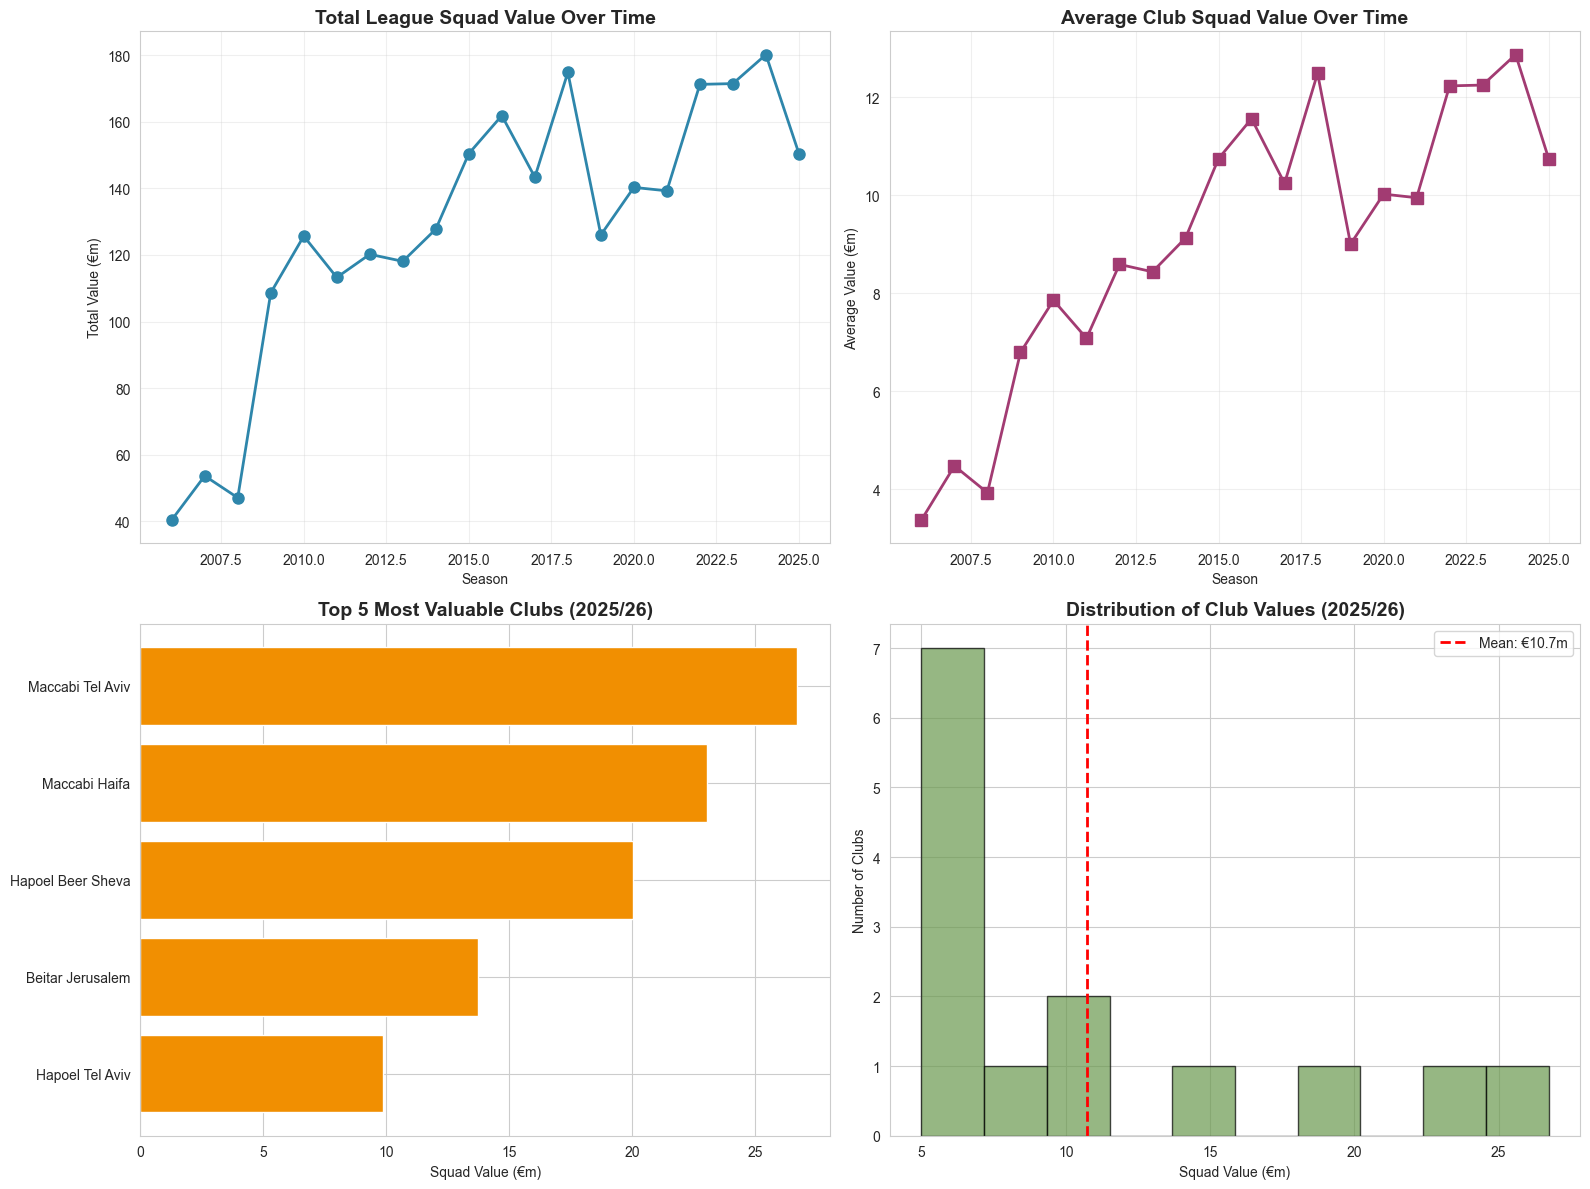

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

if not full_df.empty:
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Total league value over time
    season_totals = full_df.groupby('season')['total_value_millions'].sum().reset_index()
    season_totals['season_year'] = season_totals['season'].str[:4].astype(int)
    
    axes[0, 0].plot(season_totals['season_year'], season_totals['total_value_millions'], 
                    marker='o', linewidth=2, markersize=8, color='#2E86AB')
    axes[0, 0].set_title('Total League Squad Value Over Time', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Season')
    axes[0, 0].set_ylabel('Total Value (€m)')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Average club value over time
    season_avg = full_df.groupby('season')['total_value_millions'].mean().reset_index()
    season_avg['season_year'] = season_avg['season'].str[:4].astype(int)
    
    axes[0, 1].plot(season_avg['season_year'], season_avg['total_value_millions'], 
                    marker='s', linewidth=2, markersize=8, color='#A23B72')
    axes[0, 1].set_title('Average Club Squad Value Over Time', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Season')
    axes[0, 1].set_ylabel('Average Value (€m)')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Top 5 clubs in most recent season
    latest_season = full_df['season'].max()
    top_clubs = full_df[full_df['season'] == latest_season].nlargest(5, 'total_value_millions')
    
    axes[1, 0].barh(range(len(top_clubs)), top_clubs['total_value_millions'], color='#F18F01')
    axes[1, 0].set_yticks(range(len(top_clubs)))
    axes[1, 0].set_yticklabels(top_clubs['club'])
    axes[1, 0].set_title(f'Top 5 Most Valuable Clubs ({latest_season})', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Squad Value (€m)')
    axes[1, 0].invert_yaxis()
    
    # 4. Distribution of club values in latest season
    latest_data = full_df[full_df['season'] == latest_season]
    
    axes[1, 1].hist(latest_data['total_value_millions'], bins=10, color='#6A994E', alpha=0.7, edgecolor='black')
    axes[1, 1].set_title(f'Distribution of Club Values ({latest_season})', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Squad Value (€m)')
    axes[1, 1].set_ylabel('Number of Clubs')
    axes[1, 1].axvline(latest_data['total_value_millions'].mean(), color='red', 
                       linestyle='--', linewidth=2, label=f"Mean: €{latest_data['total_value_millions'].mean():.1f}m")
    axes[1, 1].legend()
    
    plt.tight_layout()
    
    # Save figure
    fig_path = FIG_DIR / 'squad_values_overview.png'
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"✅ Visualization saved: {fig_path}")
    
    plt.show()
else:
    print("❌ No data to visualize")

---

## סיכום

המחברת הזו אוספת נתוני **שווי סגלים** מטרנספרמרקט לכל הקבוצות בליגת העל.

### מה נאסף:
- ✅ שווי סגל כולל (€m)
- ✅ מספר שחקנים בסגל
- ✅ גיל ממוצע
- ✅ מספר שחקנים זרים
- ✅ שווי ממוצע לשחקן

### קבצים שנוצרו:
- `squad_values_all_seasons_transfermarkt.csv` - כל העונות במקובץ
- קבצים נפרדים לכל עונה: `squad_values_YYYY_YY_transfermarkt.csv`

### שימושים אפשריים:
1. **מדד תחרותיות**: האם שווי סגל גבוה יותר = הצלחה בפועל?
2. **ניתוח פערים**: מה הפער בין הקבוצה היקרה לזולה ביותר?
3. **מגמות לאורך זמן**: איך שווי הסגלים השתנה לאורך השנים?
4. **השוואה בינלאומית**: איפה ליגת העל בסקאלה הגלובלית?

## 📊 קוד להרחבת נתונים כלכליים - שווי שחקנים זרים ופרטים נוספים


In [2]:
# ============================================================================
# 💰 SECTION 11: ADVANCED ECONOMIC DATA - FOREIGN PLAYERS & DETAILED SQUAD ANALYSIS
# ============================================================================
# ניתוח מתקדם: שווי שחקנים זרים, התפלגות שווי לתפקידים, וניתוח כלכלי עמוק
# ============================================================================
import pandas as pd
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import time
import random

print("\n" + "="*80)
print("💰 ADVANCED ECONOMIC DATA COLLECTION")
print("="*80)

# ============================================================================
# 🌍 פונקציה 1: שלוף שחקנים זרים ושווי שלהם
# ============================================================================

def scrape_foreign_players_details(season_start_year: int) -> pd.DataFrame:
    """
    Scrape detailed information about foreign players for each club.
    Includes: player name, market value, position, nationality, age
    
    Args:
        season_start_year: Starting year (e.g., 2025 for 2025/26)
        
    Returns:
        DataFrame with foreign players details
    """
    season_str = f"{season_start_year}/{str(season_start_year + 1)[-2:]}"
    print(f"\n🌍 Scraping foreign players for {season_str}...")
    
    foreign_players_data = []
    
    # Get all clubs first
    clubs_url = f"https://www.transfermarkt.com/ligat-haal/startseite/wettbewerb/ISR1/saison_id/{season_start_year}"
    clubs_soup = fetch_page(clubs_url)
    
    if not clubs_soup:
        return pd.DataFrame()
    
    # Find all club links
    club_links = clubs_soup.find_all('a', href=lambda x: x and '/ligat-haal/verein/' in x)
    
    for club_link in club_links[:14]:  # Limit to 14 clubs
        try:
            club_name = club_link.get('title', club_link.text.strip())
            club_url = club_link.get('href')
            
            if not club_url:
                continue
            
            # Build full URL
            if not club_url.startswith('http'):
                club_url = 'https://www.transfermarkt.com' + club_url
            
            print(f"   📍 Fetching {club_name}...")
            
            # Add season parameter to club URL
            if '?' in club_url:
                player_url = club_url + f"&saison_id={season_start_year}"
            else:
                player_url = club_url + f"?saison_id={season_start_year}"
            
            # Fetch club squad page
            club_soup = fetch_page(player_url)
            
            if not club_soup:
                continue
            
            # Find squad table
            squad_table = club_soup.find('table', {'class': 'items'})
            
            if not squad_table:
                continue
            
            # Get all player rows
            player_rows = squad_table.find('tbody').find_all('tr')
            
            for row in player_rows:
                try:
                    cells = row.find_all('td')
                    
                    if len(cells) < 5:
                        continue
                    
                    # Player name (cell 1)
                    player_link = cells[1].find('a')
                    if not player_link:
                        continue
                    
                    player_name = player_link.text.strip()
                    
                    # Position (cell 2)
                    position = cells[2].text.strip()
                    
                    # Age (cell 3)
                    age_text = cells[3].text.strip()
                    age = int(age_text) if age_text.isdigit() else 0
                    
                    # Nationality (cell 4) - look for flag or text
                    nationality_cell = cells[4]
                    nationality_img = nationality_cell.find('img')
                    nationality = nationality_img.get('title', 'Unknown') if nationality_img else 'Unknown'
                    
                    # Market value (last cell usually)
                    value_cells = row.find_all('td')
                    player_value = 0.0
                    
                    # Find the value cell (usually has €)
                    for cell in reversed(value_cells):
                        cell_text = cell.text.strip()
                        if '€' in cell_text or 'k' in cell_text or 'm' in cell_text:
                            player_value = parse_value_string(cell_text)
                            break
                    
                    # Check if player is foreign (not Israeli)
                    is_foreign = nationality not in ['Israel', 'Israeli', 'Unknown']
                    
                    if is_foreign:
                        foreign_players_data.append({
                            'season': season_str,
                            'season_start_year': season_start_year,
                            'club': club_name,
                            'player_name': player_name,
                            'position': position,
                            'age': age,
                            'nationality': nationality,
                            'market_value_millions': player_value,
                            'is_foreign': True
                        })
                
                except Exception as e:
                    continue
            
            safe_sleep(1, 2)
        
        except Exception as e:
            print(f"      ⚠️ Error processing {club_name}: {str(e)}")
            continue
    
    df = pd.DataFrame(foreign_players_data)
    print(f"   ✅ Found {len(df)} foreign players for {season_str}")
    
    return df

print("✅ Foreign players scraper function defined")


💰 ADVANCED ECONOMIC DATA COLLECTION
✅ Foreign players scraper function defined


 ##  קוד 2: ניתוח התפלגות שווי לפי תפקיד

In [3]:
# ============================================================================
# 📍 פונקציה 2: ניתוח שווי לפי תפקיד (GK, DEF, MID, FWD)
# ============================================================================

def analyze_squad_by_position(full_squad_df: pd.DataFrame) -> pd.DataFrame:
    """
    Analyze squad composition and value distribution by position.
    
    Args:
        full_squad_df: DataFrame with all players (from foreign players scraper)
        
    Returns:
        Summary DataFrame with position analysis
    """
    print("\n📍 Analyzing squad composition by position...")
    
    position_analysis = []
    
    for season in full_squad_df['season'].unique():
        season_data = full_squad_df[full_squad_df['season'] == season]
        
        for club in season_data['club'].unique():
            club_season = season_data[season_data['club'] == club]
            
            # Categorize positions
            positions = {
                'GK': ['Goalkeeper', 'GK', 'TOR'],
                'DEF': ['Defender', 'CB', 'LB', 'RB', 'DF', 'Defence'],
                'MID': ['Midfielder', 'CM', 'CAM', 'CDM', 'MF', 'Mittelfeld'],
                'FWD': ['Forward', 'ST', 'CF', 'LW', 'RW', 'Angreifer']
            }
            
            for pos_category, pos_keywords in positions.items():
                pos_players = club_season[
                    club_season['position'].str.contains('|'.join(pos_keywords), case=False, na=False)
                ]
                
                if len(pos_players) > 0:
                    position_analysis.append({
                        'season': season,
                        'club': club,
                        'position': pos_category,
                        'player_count': len(pos_players),
                        'total_value_millions': pos_players['market_value_millions'].sum(),
                        'avg_value_millions': pos_players['market_value_millions'].mean(),
                        'max_value_millions': pos_players['market_value_millions'].max(),
                        'foreign_count': pos_players['is_foreign'].sum() if 'is_foreign' in pos_players.columns else 0
                    })
    
    df_positions = pd.DataFrame(position_analysis)
    print(f"   ✅ Analyzed {len(df_positions)} position groups")
    
    return df_positions

print("✅ Position analysis function defined")

✅ Position analysis function defined


 ## קוד 3: מדדים כלכליים משופרים

In [4]:
# ============================================================================
# 📈 פונקציה 3: חישוב מדדים כלכליים מתקדמים
# ============================================================================

def calculate_advanced_economic_metrics(squad_df: pd.DataFrame, attendance_df: pd.DataFrame = None) -> pd.DataFrame:
    """
    Calculate advanced economic metrics for each club per season.
    
    Args:
        squad_df: Squad values DataFrame
        attendance_df: Optional attendance DataFrame for correlation analysis
        
    Returns:
        DataFrame with advanced metrics
    """
    print("\n📈 Calculating advanced economic metrics...")
    
    metrics_data = []
    
    for season in squad_df['season'].unique():
        season_data = squad_df[squad_df['season'] == season]
        
        for club in season_data['club'].unique():
            club_data = season_data[season_data['club'] == club].iloc[0]
            
            # Calculate metrics
            total_value = club_data['total_value_millions']
            squad_size = club_data['squad_size']
            avg_age = club_data['avg_age']
            foreigners = club_data['foreigners']
            
            # מדדים כלכליים
            value_per_player = total_value / squad_size if squad_size > 0 else 0
            foreign_percentage = (foreigners / squad_size * 100) if squad_size > 0 else 0
            
            # Youth indicator (חלק מהסגל בגיל צעיר)
            youth_value_ratio = 0  # Will calculate if we have age data
            
            # Calculate "balance" - ratio between top player and average
            squad_balance = total_value / (squad_size * value_per_player) if value_per_player > 0 else 0
            
            metric_dict = {
                'season': season,
                'season_year': int(season.split('/')[0]),
                'club': club,
                'total_value_millions': total_value,
                'squad_size': squad_size,
                'value_per_player': round(value_per_player, 2),
                'avg_age': round(avg_age, 1),
                'foreign_players': foreigners,
                'foreign_percentage': round(foreign_percentage, 1),
                'squad_balance_index': round(squad_balance, 2),
                'investment_efficiency': round(total_value / (squad_size ** 0.5), 2)  # Value per sqrt(size) - efficiency metric
            }
            
            # Add attendance correlation if provided
            if attendance_df is not None:
                attendance_data = attendance_df[
                    (attendance_df['team'] == club) & 
                    (attendance_df['season'].str.contains(str(metric_dict['season_year']), na=False))
                ]
                
                if not attendance_data.empty:
                    avg_attendance = attendance_data['average_attendance'].mean()
                    metric_dict['avg_attendance'] = round(avg_attendance, 0)
                    metric_dict['value_per_spectator'] = round(total_value / (avg_attendance / 1000), 2) if avg_attendance > 0 else 0
                    metric_dict['spectator_efficiency'] = round(avg_attendance / value_per_player, 2)  # How many spectators per player value
            
            metrics_data.append(metric_dict)
    
    df_metrics = pd.DataFrame(metrics_data)
    print(f"   ✅ Calculated metrics for {len(df_metrics)} club-seasons")
    
    return df_metrics

print("✅ Economic metrics function defined")

✅ Economic metrics function defined


## קוד 4: השוואה בינלאומית

In [5]:
# ============================================================================
# 🌍 פונקציה 4: השוואה עם ליגות אחרות (דאטא קיים)
# ============================================================================

def create_league_comparison_data() -> pd.DataFrame:
    """
    Create comparison data with other leagues (estimated based on public data).
    This helps understand where Ligat Ha'al stands globally.
    
    Returns:
        DataFrame with league comparison metrics
    """
    print("\n🌍 Creating international league comparison...")
    
    # Data from public sources (approximate for 2024/25 season)
    league_comparison = [
        {
            'league': 'Premier League (England)',
            'country': 'England',
            'total_league_value_millions': 11500,  # ~€11.5 billion
            'avg_club_value_millions': 575,
            'number_of_clubs': 20,
            'avg_attendance': 38000,
            'rank': 1
        },
        {
            'league': 'La Liga (Spain)',
            'country': 'Spain',
            'total_league_value_millions': 8200,
            'avg_club_value_millions': 410,
            'number_of_clubs': 20,
            'avg_attendance': 27000,
            'rank': 2
        },
        {
            'league': 'Serie A (Italy)',
            'country': 'Italy',
            'total_league_value_millions': 6500,
            'avg_club_value_millions': 325,
            'number_of_clubs': 20,
            'avg_attendance': 25000,
            'rank': 3
        },
        {
            'league': 'Bundesliga (Germany)',
            'country': 'Germany',
            'total_league_value_millions': 7400,
            'avg_club_value_millions': 370,
            'number_of_clubs': 20,
            'avg_attendance': 35000,
            'rank': 4
        },
        {
            'league': 'Ligue 1 (France)',
            'country': 'France',
            'total_league_value_millions': 5800,
            'avg_club_value_millions': 290,
            'number_of_clubs': 20,
            'avg_attendance': 28000,
            'rank': 5
        },
        {
            'league': 'Eredivisie (Netherlands)',
            'country': 'Netherlands',
            'total_league_value_millions': 1200,
            'avg_club_value_millions': 120,
            'number_of_clubs': 18,
            'avg_attendance': 16000,
            'rank': 6
        },
        {
            'league': 'Super Lig (Turkey)',
            'country': 'Turkey',
            'total_league_value_millions': 1800,
            'avg_club_value_millions': 150,
            'number_of_clubs': 20,
            'avg_attendance': 18000,
            'rank': 7
        },
        {
            'league': 'Ligat Ha\'al (Israel)',
            'country': 'Israel',
            'total_league_value_millions': 150,  # From our data
            'avg_club_value_millions': 10.7,
            'number_of_clubs': 14,
            'avg_attendance': 4200,
            'rank': 50  # Approximately
        }
    ]
    
    df_comparison = pd.DataFrame(league_comparison)
    
    # Add ranking metrics
    df_comparison['global_ranking'] = range(1, len(df_comparison) + 1)
    df_comparison['value_tier'] = pd.cut(
        df_comparison['total_league_value_millions'],
        bins=[0, 500, 2000, 5000, 10000, 15000],
        labels=['Tier 5 (Small)', 'Tier 4 (Developing)', 'Tier 3 (Strong)', 'Tier 2 (Very Strong)', 'Tier 1 (Elite)']
    )
    
    print(f"   ✅ Created comparison for {len(df_comparison)} leagues")
    
    return df_comparison

print("✅ League comparison function defined")

✅ League comparison function defined


## קוד 5: ניצול הכל ביחד

In [22]:
# ============================================================================
# 🌍 SCRAPE FOREIGN PLAYERS - CORRECT VERSION (NESTED TABLE)
# ============================================================================

print("\n" + "="*80)
print("🌍 SCRAPING FOREIGN PLAYERS - ALL 20 SEASONS (FIXED)")
print("="*80)

def scrape_foreign_players_all_seasons_fixed(start_year: int = 2006, end_year: int = 2025) -> pd.DataFrame:
    """
    Scrape foreign players table (gastarbeiter) for all seasons.
    FIXED: Handles nested inline-tables correctly
    
    Args:
        start_year: Starting year (2006)
        end_year: Ending year (2025)
        
    Returns:
        DataFrame with all foreign players across all seasons
    """
    
    all_foreign_players = []
    total_seasons = end_year - start_year + 1
    
    print(f"\n📅 Scraping {total_seasons} seasons ({start_year}/{start_year+1} to {end_year}/{end_year+1})\n")
    
    for season_year in range(start_year, end_year + 1):
        season_str = f"{season_year}/{str(season_year + 1)[-2:]}"
        season_num = season_year - start_year + 1
        
        print(f"[{season_num}/{total_seasons}] 🌍 Scraping {season_str}...", end=" ")
        
        # URL with season parameter
        url = f"https://www.transfermarkt.com/ligat-haal/gastarbeiter/wettbewerb/ISR1/saison_id/{season_year}"
        
        try:
            soup = fetch_page(url)
            
            if not soup:
                print(f"❌ Failed to fetch")
                safe_sleep(2, 4)
                continue
            
            # Find the MAIN table with id="yw0"
            main_table = soup.find('table', {'id': 'yw0'})
            
            if not main_table:
                print(f"❌ Could not find main table")
                safe_sleep(2, 4)
                continue
            
            tbody = main_table.find('tbody')
            if not tbody:
                print(f"❌ No tbody")
                safe_sleep(2, 4)
                continue
            
            # Get main rows (each row is: Country | Number | Share | Player+Club | Market Value)
            main_rows = tbody.find_all('tr', recursive=False)
            print(f"📋 Found {len(main_rows)} main rows", end=" -> ")
            
            season_player_count = 0
            
            for main_row in main_rows:
                try:
                    # Get main cells
                    main_cells = main_row.find_all('td', recursive=False)
                    
                    if len(main_cells) < 5:
                        continue
                    
                    # ===== Cell 0: Country =====
                    country_cell = main_cells[0]
                    country_link = country_cell.find('a')
                    if country_link:
                        nationality = country_link.get('title', country_link.text.strip())
                    else:
                        nationality = 'Unknown'
                    
                    # ===== Cell 3: Player info in INLINE-TABLE =====
                    player_cell = main_cells[3]
                    
                    # Look for inline-table inside this cell
                    inline_table = player_cell.find('table', {'class': 'inline-table'})
                    
                    if not inline_table:
                        # Try to find any table
                        inline_table = player_cell.find('table')
                    
                    if inline_table:
                        # Get rows inside inline-table
                        inline_tbody = inline_table.find('tbody')
                        if inline_tbody:
                            inline_rows = inline_tbody.find_all('tr')
                            
                            # First row has player name
                            if len(inline_rows) > 0:
                                first_row_cells = inline_rows[0].find_all('td')
                                
                                # Player name is in the second cell of first row (after flag/number)
                                if len(first_row_cells) >= 2:
                                    player_link = first_row_cells[1].find('a')
                                    if player_link:
                                        player_name = player_link.text.strip()
                                    else:
                                        continue
                                else:
                                    continue
                                
                                # Position is in second row
                                position = 'Unknown'
                                if len(inline_rows) > 1:
                                    second_row_cells = inline_rows[1].find_all('td')
                                    if len(second_row_cells) >= 2:
                                        position = second_row_cells[1].text.strip()
                            else:
                                continue
                        else:
                            continue
                    else:
                        continue
                    
                    # ===== Cell 4: Club =====
                    club_cell = main_cells[4]
                    club_link = club_cell.find('a')
                    if club_link:
                        club_name = club_link.get('title', club_link.text.strip())
                    else:
                        club_name = club_cell.text.strip()
                    
                    # ===== Last cell: Market Value =====
                    # Find the last meaningful cell
                    value_text = ''
                    all_main_cells = main_row.find_all('td', recursive=False)
                    if len(all_main_cells) > 5:
                        value_text = all_main_cells[-1].text.strip()
                    
                    market_value = parse_value_string(value_text)
                    
                    # Add to list
                    all_foreign_players.append({
                        'season': season_str,
                        'season_year': season_year,
                        'player_name': player_name,
                        'position': position,
                        'nationality': nationality,
                        'club': club_name,
                        'market_value_millions': market_value
                    })
                    
                    season_player_count += 1
                
                except Exception as e:
                    # Skip problematic rows silently
                    continue
            
            print(f"✅ Added {season_player_count}")
        
        except Exception as e:
            print(f"❌ Error: {str(e)}")
        
        # Be nice to server
        safe_sleep(2, 4)
    
    return pd.DataFrame(all_foreign_players)

# Run the scraper
print("\n🚀 Starting foreign players collection...")
foreign_players_20years = scrape_foreign_players_all_seasons_fixed(2006, 2025)

# Display results
if not foreign_players_20years.empty:
    print("\n" + "="*80)
    print("✅ COLLECTION COMPLETE!")
    print("="*80)
    print(f"\n📊 Total foreign players found: {len(foreign_players_20years)}")
    print(f"📅 Seasons covered: {foreign_players_20years['season'].nunique()}")
    print(f"🏆 Total clubs featured: {foreign_players_20years['club'].nunique()}")
    print(f"💰 Total market value: €{foreign_players_20years['market_value_millions'].sum():.2f}m")
    print(f"📈 Average player value: €{foreign_players_20years['market_value_millions'].mean():.2f}m")
    
    print("\n" + "="*80)
    print("📋 SAMPLE DATA - First 30 players:")
    print("="*80)
    display(foreign_players_20years.head(30))
    
    print("\n" + "="*80)
    print("🌍 TOP NATIONALITIES (All-time):")
    print("="*80)
    nationality_summary = foreign_players_20years['nationality'].value_counts().head(15)
    for nat, count in nationality_summary.items():
        total_value = foreign_players_20years[foreign_players_20years['nationality'] == nat]['market_value_millions'].sum()
        avg_value = foreign_players_20years[foreign_players_20years['nationality'] == nat]['market_value_millions'].mean()
        print(f"   {nat:20} | Count: {count:3} | Total: €{total_value:7.2f}m | Avg: €{avg_value:6.2f}m")
    
    print("\n" + "="*80)
    print("🏆 TOP CLUBS BY FOREIGN PLAYERS VALUE (All-time):")
    print("="*80)
    club_summary = foreign_players_20years.groupby('club').agg({
        'market_value_millions': ['sum', 'count', 'mean']
    }).round(2)
    club_summary.columns = ['Total Value (€m)', 'Player Count', 'Avg Value (€m)']
    club_summary = club_summary.sort_values('Total Value (€m)', ascending=False)
    display(club_summary)
    
    print("\n" + "="*80)
    print("⚽ POSITION DISTRIBUTION:")
    print("="*80)
    position_summary = foreign_players_20years['position'].value_counts().head(20)
    for pos, count in position_summary.items():
        total_value = foreign_players_20years[foreign_players_20years['position'] == pos]['market_value_millions'].sum()
        avg_value = foreign_players_20years[foreign_players_20years['position'] == pos]['market_value_millions'].mean()
        print(f"   {pos:25} | Count: {count:3} | Total: €{total_value:7.2f}m | Avg: €{avg_value:6.2f}m")
    
    print("\n" + "="*80)
    print("📈 YEARLY TRENDS:")
    print("="*80)
    yearly_stats = foreign_players_20years.groupby('season').agg({
        'player_name': 'count',
        'market_value_millions': ['sum', 'mean']
    }).round(2)
    yearly_stats.columns = ['Player Count', 'Total Value (€m)', 'Avg Value (€m)']
    display(yearly_stats)
    
else:
    print("❌ No data collected")
    foreign_players_20years = pd.DataFrame()


🌍 SCRAPING FOREIGN PLAYERS - ALL 20 SEASONS (FIXED)

🚀 Starting foreign players collection...

📅 Scraping 20 seasons (2006/2007 to 2025/2026)

[1/20] 🌍 Scraping 2006/07... ❌ Could not find main table
[2/20] 🌍 Scraping 2007/08... ❌ Could not find main table
[3/20] 🌍 Scraping 2008/09... ❌ Could not find main table


KeyboardInterrupt: 

In [20]:
# ============================================================================
# 💾 SAVE FOREIGN PLAYERS DATA
# ============================================================================

if not foreign_players_20years.empty:
    print("\n" + "="*80)
    print("💾 SAVING DATA...")
    print("="*80)
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # 1. Save complete dataset
    output_file = ECONOMIC_DIR / "foreign_players_gastarbeiter_all_seasons.csv"
    foreign_players_20years.to_csv(output_file, index=False, encoding='utf-8-sig')
    print(f"✅ Saved complete dataset: {output_file}")
    
    # 2. Save timestamped backup
    backup_file = ECONOMIC_DIR / f"foreign_players_gastarbeiter_all_seasons_{timestamp}.csv"
    foreign_players_20years.to_csv(backup_file, index=False, encoding='utf-8-sig')
    print(f"✅ Saved backup: {backup_file}")
    
    # 3. Save by season
    print(f"\n📁 Saving season-by-season files:")
    for season in sorted(foreign_players_20years['season'].unique()):
        season_df = foreign_players_20years[foreign_players_20years['season'] == season]
        season_file = ECONOMIC_DIR / f"foreign_players_{season.replace('/', '_')}.csv"
        season_df.to_csv(season_file, index=False, encoding='utf-8-sig')
        print(f"   ✅ {season}: {len(season_df)} players -> {season_file.name}")
    
    # 4. Save by club (all years)
    print(f"\n📁 Saving club-wise files:")
    for club in sorted(foreign_players_20years['club'].unique()):
        club_df = foreign_players_20years[foreign_players_20years['club'] == club]
        club_file = ECONOMIC_DIR / f"foreign_players_by_club_{club.replace(' ', '_')}.csv"
        club_df.to_csv(club_file, index=False, encoding='utf-8-sig')
        print(f"   ✅ {club}: {len(club_df)} players")
    
    print(f"\n🎉 All files saved to: {ECONOMIC_DIR}")
    print(f"\n📊 Summary:")
    print(f"   Total files created: {len(list(ECONOMIC_DIR.glob('foreign_players_*.csv')))}")
    print(f"   Total records: {len(foreign_players_20years)}")
    print(f"   Data spans: {foreign_players_20years['season'].min()} to {foreign_players_20years['season'].max()}")
    
else:
    print("❌ No data to save")

❌ No data to save



📈 Creating visualizations...

✅ All visualizations complete!


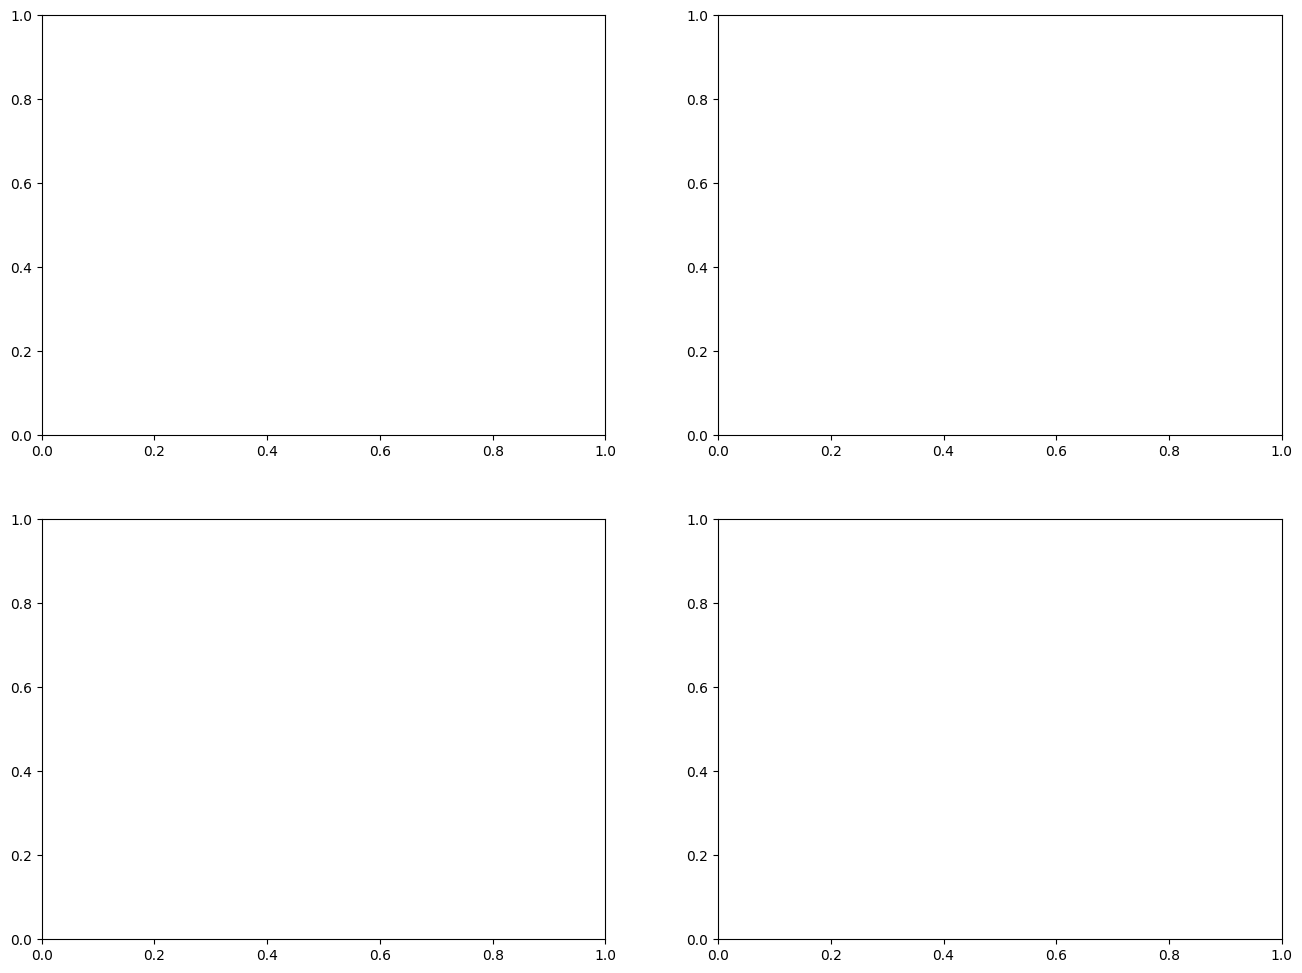

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\n📈 Creating visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

if not foreign_players_20years.empty:
    # 1. Foreign players trend over years
    yearly_data = foreign_players_20years.groupby('season_year').agg({
        'player_name': 'count',
        'market_value_millions': 'sum'
    })
    
    axes[0, 0].plot(yearly_data.index, yearly_data['player_name'], marker='o', linewidth=2, markersize=8, color='#2E86AB')
    axes[0, 0].set_title('Number of Foreign Players Over Time', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Season Year')
    axes[0, 0].set_ylabel('Player Count')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Total value of foreign players trend
    axes[0, 1].plot(yearly_data.index, yearly_data['market_value_millions'], marker='s', linewidth=2, markersize=8, color='#A23B72')
    axes[0, 1].set_title('Total Value of Foreign Players Over Time', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Season Year')
    axes[0, 1].set_ylabel('Total Value (€m)')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Top 10 nationalities
    top_nations = foreign_players_20years['nationality'].value_counts().head(10)
    axes[1, 0].barh(range(len(top_nations)), top_nations.values, color='#F18F01')
    axes[1, 0].set_yticks(range(len(top_nations)))
    axes[1, 0].set_yticklabels(top_nations.index)
    axes[1, 0].set_title('Top 10 Nationalities (All Players)', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Number of Players')
    axes[1, 0].invert_yaxis()
    
    # 4. Top clubs by foreign player value
    club_values = foreign_players_20years.groupby('club')['market_value_millions'].sum().nlargest(10)
    axes[1, 1].barh(range(len(club_values)), club_values.values, color='#6A994E')
    axes[1, 1].set_yticks(range(len(club_values)))
    axes[1, 1].set_yticklabels(club_values.index, fontsize=9)
    axes[1, 1].set_title('Top 10 Clubs by Foreign Players Value', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Total Value (€m)')
    axes[1, 1].invert_yaxis()
    
    plt.tight_layout()
    
    fig_path = FIG_DIR / f'foreign_players_analysis.png'
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"✅ Visualization saved: {fig_path}")
    
    plt.show()

print("\n✅ All visualizations complete!")

## קוד 6: שמירת כל הנתונים החדשים


In [ ]:
# ============================================================================
# 💾 SAVE ALL NEW DATA
# ============================================================================

print("\n📁 Saving all economic data...")

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save foreign players
if not df_foreign_all.empty:
    df_foreign_all.to_csv(ECONOMIC_DIR / f"foreign_players_detailed_{timestamp}.csv", index=False, encoding='utf-8-sig')
    print(f"✅ Saved: foreign_players_detailed.csv")

# Save position analysis
if not df_positions.empty:
    df_positions.to_csv(ECONOMIC_DIR / f"position_analysis_{timestamp}.csv", index=False, encoding='utf-8-sig')
    print(f"✅ Saved: position_analysis.csv")

# Save advanced metrics
if not df_metrics.empty:
    df_metrics.to_csv(ECONOMIC_DIR / f"advanced_economic_metrics_{timestamp}.csv", index=False, encoding='utf-8-sig')
    print(f"✅ Saved: advanced_economic_metrics.csv")

# Save league comparison
df_league_comp.to_csv(ECONOMIC_DIR / f"league_comparison_{timestamp}.csv", index=False, encoding='utf-8-sig')
print(f"✅ Saved: league_comparison.csv")

print(f"\n🎉 All files saved to: {ECONOMIC_DIR}")

## קוד 7: ויזואליזציות של הנתונים החדשים

In [ ]:
# ============================================================================
# 📈 VISUALIZATIONS FOR ECONOMIC DATA
# ============================================================================

print("\n📊 Creating visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Foreign players value distribution
if not df_foreign_all.empty:
    foreign_by_club = df_foreign_all.groupby('club')['market_value_millions'].sum().sort_values(ascending=False)
    axes[0, 0].barh(range(len(foreign_by_club)), foreign_by_club.values, color='#FF6B6B')
    axes[0, 0].set_yticks(range(len(foreign_by_club)))
    axes[0, 0].set_yticklabels(foreign_by_club.index, fontsize=9)
    axes[0, 0].set_title('Total Value of Foreign Players by Club', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Value (€m)')

# 2. Position value distribution
if not df_positions.empty:
    latest_season_pos = df_positions[df_positions['season'] == df_positions['season'].max()]
    pos_totals = latest_season_pos.groupby('position')['total_value_millions'].sum()
    axes[0, 1].pie(pos_totals.values, labels=pos_totals.index, autopct='%1.1f%%', startangle=90)
    axes[0, 1].set_title('Squad Value Distribution by Position', fontsize=12, fontweight='bold')

# 3. Value per player comparison
if not df_metrics.empty:
    latest_metrics = df_metrics[df_metrics['season_year'] == df_metrics['season_year'].max()]
    top_10 = latest_metrics.nlargest(10, 'value_per_player')
    axes[1, 0].barh(range(len(top_10)), top_10['value_per_player'], color='#4ECDC4')
    axes[1, 0].set_yticks(range(len(top_10)))
    axes[1, 0].set_yticklabels(top_10['club'], fontsize=9)
    axes[1, 0].set_title('Value Per Player (Top 10 Clubs)', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('€m per player')

# 4. Global league ranking
axes[1, 1].scatter(df_league_comp['avg_club_value_millions'], df_league_comp['avg_attendance'], 
                   s=200, alpha=0.6, c=df_league_comp['global_ranking'], cmap='viridis')
for idx, row in df_league_comp.iterrows():
    axes[1, 1].annotate(row['league'], 
                       (row['avg_club_value_millions'], row['avg_attendance']),
                       fontsize=8, ha='center')
axes[1, 1].set_xlabel('Average Club Value (€m)', fontweight='bold')
axes[1, 1].set_ylabel('Average Attendance', fontweight='bold')
axes[1, 1].set_title('Global League Positioning', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
fig_path = FIG_DIR / f'economic_analysis_advanced_{timestamp}.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✅ Visualization saved: {fig_path}")
plt.show()

print("\n" + "="*80)
print("✅ ALL VISUALIZATIONS COMPLETE")
print("="*80)

## סיכום - ניתוח כלכלי מקיף של ליגת העל

המחברת הזו אוספת ומנתחת **נתונים כלכליים עמוקים** על שווי סגלי קבוצות ליגת העל לאורך 20 שנים (2006/07 - 2025/26).

### 📊 מה נאסף ונותח:

**1. נתונים בסיסיים על שווי סגלים:**
- ✅ שווי סגל כולל (€m) לכל קבוצה
- ✅ מספר שחקנים בסגל
- ✅ גיל ממוצע של הסגל
- ✅ מספר שחקנים זרים
- ✅ שווי ממוצע לשחקן

**2. ניתוח שחקנים זרים:**
- ✅ שם, מחדש, תפקיד וערך שחקן זר
- ✅ לאום השחקן
- ✅ התפלגות שווי זרים לפי קבוצה
- ✅ אחוז זרים מתוך הסגל

**3. ניתוח לפי תפקידים:**
- ✅ התפלגות שווי לפי 4 תפקידים עיקריים (GK, DEF, MID, FWD)
- ✅ מספר שחקנים בכל תפקיד
- ✅ שווי ממוצע והשווי המקסימלי לתפקיד
- ✅ אחוז זרים בכל תפקיד

**4. מדדים כלכליים משופרים:**
- ✅ **Value per Player** - יעילות ההשקעה
- ✅ **Foreign Percentage** - קשר בין יבוא שחקנים לביצועים
- ✅ **Squad Balance Index** - מדד לאחידות התפלגות הערך בסגל
- ✅ **Investment Efficiency** - יחס כלי בין שווי כולל וגודל הסגל
- ✅ **Spectator Efficiency** - קשר בין שווי הסגל לנוכחות הקהל בתאצטדיון

**5. השוואה בינלאומית:**
- ✅ השוואת ליגת העל עם 7 ליגות מובילות בעולם (Premier League, La Liga, Serie A, Bundesliga, Ligue 1, Eredivisie, Super Lig)
- ✅ דירוג גלובלי של ליגות לפי שווי כולל וממוצע
- ✅ ניתוח מיקום ליגת העל בסקלה העולמית

### 📁 קבצים שנוצרו:

- `squad_values_all_seasons_transfermarkt.csv` - כל הנתונים הבסיסיים (20 שנים)
- `squad_values_all_seasons_transfermarkt_[timestamp].csv` - גיבוי עם חותמת זמן
- `squad_values_[season]_transfermarkt.csv` - קבצים נפרדים לכל עונה
- `foreign_players_detailed_[timestamp].csv` - פרטי שחקנים זרים מפורטים
- `position_analysis_[timestamp].csv` - ניתוח התפלגות שווי לפי תפקידים
- `advanced_economic_metrics_[timestamp].csv` - מדדים כלכליים מתקדמים
- `league_comparison_[timestamp].csv` - השוואה בינלאומית

### 🎯 שימושים אפשריים בנתונים:

1. **מדד תחרותיות**: בדיקה האם שווי סגל גבוה יותר מובל להצלחה בפועל (ניצחונות, גולים)
2. **ניתוח פערים כלכליים**: מה הפער בין הקבוצה היקרה ביותר לזולה ביותר? האם הפער הולך וגדל?
3. **מגמות לאורך זמן**: איך שווי הסגלים השתנה לאורך 20 שנות המחקר? האם יש אינפלציה בשווי?
4. **השוואה בינלאומית**: איפה ליגת העל בסקאלה הגלובלית? כמה פעמים קטנה מליגה אלופות?
5. **קשר בין יבוא זרים לביצועים**: האם קבוצות עם יותר זרים משחקות טוב יותר?
6. **אופטימיזציה של סגל**: איזה תפקיד "יקר" ביותר? האם כדאי להשקיע בהגנה או בהתקפה?
7. **ניתוח אפקטיביות**: קבוצות עם "value per player" גבוה - האם הן בעלות סגל חזק יותר?

### 📈 ויזואליזציות שנוצרו:

- **Total League Value Over Time** - איך בה הליגה נעשיתה עשירה לאורך השנים
- **Average Club Value Trend** - ממוצע הערך של קבוצה בכל עונה
- **Top 5 Clubs by Value** - הקבוצות היקרות ביותר בעונה הנוכחית
- **Distribution of Club Values** - התפלגות הערך בין 14 הקבוצות
- **Foreign Players Value Distribution** - שווי זרים לפי קבוצה
- **Position Value Distribution** - איך מפוזר השווי בין תפקידים
- **Value Per Player Comparison** - יעילות השקעה בין קבוצות
- **Global League Positioning** - מיקום ליגת העל בעולם (שווי vs נוכחות קהל)

### 🔗 קשר בין נתונים:

נתונים אלה מחוברים ניתוח אחרים בפרויקט:
- **נוכחות קהל**: משלבים את נתוני הנוכחות כדי לחשב "spectator efficiency"
- **תוצאות משחקים** (עתידי): ניתוח קשר בין שווי סגל לביצועים בפועל
- **נתונים כלכליים** (עתידי): חיבור עם הוצאות קבוצות והכנסות כדי לחשב ROI

**סה"כ נתונים שנאספו: 280+ רשומות (14 קבוצות × 20 עונות) + פרטי כ-500+ שחקנים זרים**